### TP AMS O7 : LBM D1Q2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Exercice 1

#### Q1

Afin d'être consistant avec une équation d'advection, on doit prendre $m_1^{éq} : m_0 \mapsto c\cdot m_0$ avec $c\in\mathbb{R}$ la vitesse de transport.

#### Q2

Suivent un script retournant la solution exacte de l'équation d'advection à partir d'une fonction donnant la distribution initiale.

Ensuite est codée une classe qui implémente la méthode D1Q2. Des conditions aux limites périodiques sont implémentées. Deux types d'implémentations ont été faites, l'une "fast" permet de résoudre sans garder l'historique, elle est plus rapide, l'autre permet de garder l'historique du calcul pour faire des figures (elle utilise les matrice M et M_inv de façon non optimale car force à faire des boucles for mais m'a permis de mieux comprendre ce que je programmais).


In [2]:
### Solution exacte de l'équation d'advection
def solve_advection(u_0, t_0, t, c):
    """
    Gives the exact solution of advection equation at time t for initial distribution u_0
    
    Args:
        - u_0 (function: x -> u_0(x)): initial distribution
        - t_0 (float): initial time
        - t (float): time at which we want the solution
        - c (float): advection speed
    """
    def u_t(x):
        return u_0(x - c*(t-t_0))
    return u_t

In [3]:
### Solution approchée par la méthode D1Q2
class LBM_D1Q2:
    def __init__(self, m_0_init, s_1, m_1_eq, nx=500, x_0=0., x_1=1., t_0=0., t_1=1., lamb=1., fast=False):
        """
        Initializes the LBM_D1Q2 class
        
        Args:
            - m_0_init (function: x -> m_0_init(x)): initial distribution of m_0
            - s_1 (float): relaxation parameter
            - m_1_eq (function: m_0 -> m_1_eq(m_0)): equilibrium distribution of m_1 in term of m_0 = f_0 + f_1
            - nx (int): number of cells
            - x_0 (float): left boundary
            - x_1 (float): right boundary
            - t_0 (float): initial time
            - t_1 (float): final time
            - lamb (float): lambda = dx/dt la vitesse du réseau
            - fast (bool): if True, the fast version of the LBM is used and the user won't have access to the intermediate steps of the LBM
        """
        self.fast = fast

        self.nx = nx
        self.dx = (x_1-x_0) / self.nx
        self.X = np.linspace(x_0-0.5*self.dx, x_1+0.5*self.dx, self.nx+2)

        self.lamb = lamb

        self.t_0, self.t_1 = t_0, t_1
        self.dt = (self.X[1]-self.X[0]) / self.lamb
        self.nt = int(np.ceil((t_1-t_0) / self.dt))

        self.true_final_time = None # on calcule à la fin de la simulation le temps final exact pour éviter
                                    # les erreurs dans le calcul de l'erreur

        self.m_1_eq = m_1_eq
        self.s_1 = s_1
        self.relax_mat = np.array([[0., 0.], [0., s_1]])

        self.M = np.array([[1, 1], [-self.lamb, self.lamb]])
        self.M_inv = np.array([[0.5, -0.5 / self.lamb], [0.5, 0.5 / self.lamb]])

        if not self.fast:
            self.f = np.zeros((self.nx+2, self.nt+1, 2))
            self.m = np.zeros((self.nx+2, self.nt+1, 2))
        else:
            self.f_0 = np.zeros((self.nx+2))
            self.f_1 = np.zeros((self.nx+2))
            self.m_0 = np.zeros((self.nx+2))
            self.m_1 = np.zeros((self.nx+2))

        self.m_0_init = m_0_init

    def initialize(self):
        """
        Initialization of the LBM
        """
        if not self.fast:
            self.m[:,0,0] = self.m_0_init(self.X)
            self.m[:,0,1] = self.m_1_eq(self.m[:,0,0])
            for ix in range(self.nx+2):
                self.f[ix,0,:] = np.matmul(self.M_inv, self.m[ix,0,:])
        else:
            self.m_0[:] = self.m_0_init(self.X)
            self.m_1[:] = self.m_1_eq(self.m_0)
            self.f_0[:] = 0.5 * (self.m_0 - self.m_1 / self.lamb)
            self.f_1[:] = 0.5 * (self.m_0 + self.m_1 / self.lamb)

    def relaxation(self, it):
        """
        Relaxation step of the LBM and computation of f from the new value of m
        
        Args:
            - it (int): time index
        """
        for ix in range(self.nx+2):
            self.m[ix,it+1,0] = self.m[ix,it,0]
            self.m[ix,it+1,1] = self.m[ix,it,1] + self.s_1 * (self.m_1_eq(self.m[ix,it,0]) - self.m[ix,it,1])
            self.f[ix,it+1,:] = np.matmul(self.M_inv, self.m[ix,it+1,:])
    
    def relaxation_fast(self):
        """
        Relaxation step of the LBM and computation of f from the new value of m
        """
        self.m_1[:] = self.m_1 + self.s_1 * (self.m_1_eq(self.m_0) - self.m_1)

        self.f_0[:] = 0.5 * (self.m_0 - self.m_1 / self.lamb)
        self.f_1[:] = 0.5 * (self.m_0 + self.m_1 / self.lamb)

    def transport(self, it):
        """
        Transport step of the LBM. Boundary conditions are implemented to be periodic here.
        
        Args:
            - it (int): time index
        """
        self.f[:,it+1,0] = np.roll(self.f[:,it+1,0], -1)
        self.f[:,it+1,1] = np.roll(self.f[:,it+1,1], 1)
        for ix in range(self.nx+2):
            self.m[ix,it+1,:] = np.matmul(self.M, self.f[ix,it+1,:])
    
    def transport_fast(self):
        """
        Transport step of the LBM. Boundary conditions are implemented to be periodic here.
        """
        self.f_0[:] = np.roll(self.f_0, -1)
        self.f_1[:] = np.roll(self.f_1, 1)

        self.m_0[:] = self.f_0 + self.f_1
        self.m_1[:] = self.lamb * (self.f_1 - self.f_0)

    def run(self):
        """
        Run the LBM in "normal" mode to have access to the intermediate steps of the LBM
        """
        self.initialize()
        t = self.t_0
        it = 0
        while t < self.t_1:
            t += self.dt
            self.relaxation(it)
            self.transport(it)
            it += 1
        self.true_final_time = t
    
    def run_fast(self):
        """
        Run the LBM in "fast" mode (no access to the intermediate steps of the LBM)
        """
        self.initialize()
        t = self.t_0
        while t < self.t_1:
            t += self.dt
            self.relaxation_fast()
            self.transport_fast()
        self.true_final_time = t

    def return_final_sol(self):
        """
        Returns the final solution of the LBM (to execute only after the LBM has been run)
        """
        if not self.fast:
            return self.m[:,-1,0]
        else:
            return self.m_0

    def plot_m_0(self, it_list, exact_sol=None):
        """
        Plots the m_0 distribution at different times along with the exact solution at final time
        
        Args:
            - it_list (list of int): list of time indices at which we want to plot the m_0 distribution
        """
        if exact_sol is not None:
            plt.plot(self.X, exact_sol, label="Exact solution", color="orange")
        for it in it_list:
            plt.plot(self.X, self.m[:,it,0], label=f"t={it*self.dt:10.2f}")
        plt.title("Solution for $s_1 = " + f"{self.s_1:10.2f}" + "$ and $\lambda=" + f"{self.lamb:10.2f}" + "$")
        plt.legend()
        plt.show()

    def plot_final_sol_exact_sol_init_dist(self, u_final, **kwargs):
        """
        Plot the final solution of the LBM, the exact solution at time t_1 and the initial distribution
        
        Args:
            - u_final (array): exact solution at time t_1
        """
        plt.plot(self.X, self.return_final_sol(), label="Approximation LBM", **kwargs)
        plt.plot(self.X, u_final, label="Solution exacte")
        plt.plot(self.X, self.m_0_init(self.X), label="Distribution initiale")
        plt.title("Final solution of the LBM and exact solution")
        plt.legend()
        plt.show()

#### Q3

On construit des fonctions tests qui sont non nulles sur un compact et nulles en dehors. Le paramètre `reg` donne une régularité globale de la fonction $\mathcal{C}^{reg}$ et une régularité $\mathcal{C}^{\infty}$ par morceaux (car polynomiale par morceaux).

La fonction `u_init` est tirée directement du dépôt github de PyLBM.

On affiche quelques exemples pour différentes régularité, par la suite on utilisera la régularité globale $\mathcal{C}^2$.

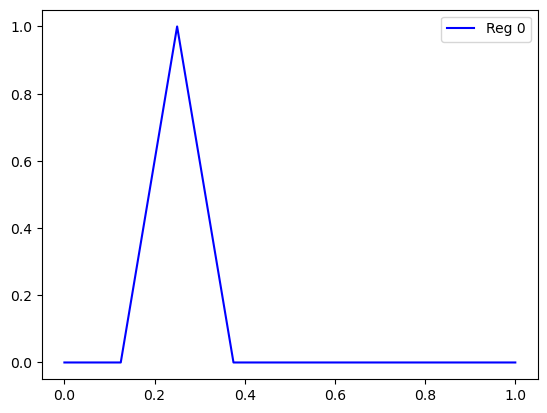

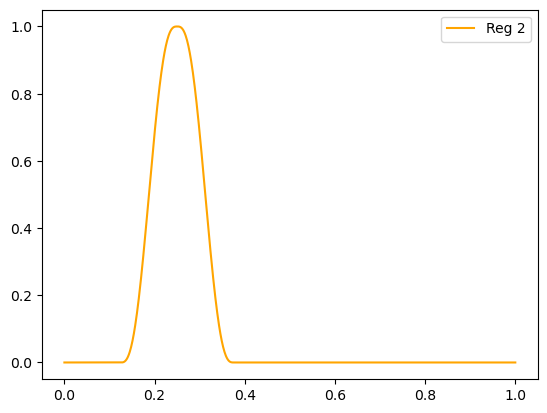

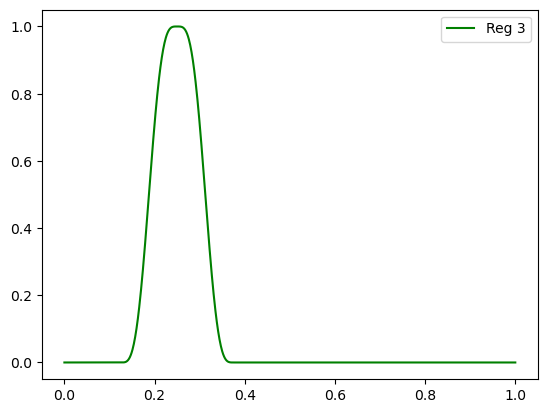

In [4]:
def u_init(x, xmin, xmax, reg):
    """
    initial condition
    """
    middle, width = 0.75 * xmin + 0.25 * xmax, 0.125 * (xmax - xmin)
    x_left, x_right = middle - width, middle + width
    output = np.zeros(x.shape)

    ind_l = np.where(np.logical_and(x > x_left, x <= middle))
    ind_r = np.where(np.logical_and(x < x_right, x > middle))
    x_sl = (x[ind_l] - x_left - 0.5 * width) / (0.5 * width)
    x_sl_k = np.copy(x_sl)
    x_sl *= x_sl
    x_sr = (x[ind_r] - middle - 0.5 * width) / (0.5 * width)
    x_sr_k = np.copy(x_sr)
    x_sr *= x_sr

    def binomial(n, k):
        if 0 <= k <= n:
            ntok = 1
            ktok = 1
            for t in range(1, min(k, n - k) + 1):
                ntok *= n
                ktok *= t
                n -= 1
            return ntok // ktok
        else:
            return 0

    cte = 0.0
    for k in range(reg + 1):
        coeff = (-1) ** k * binomial(reg, k) / (2 * k + 1)
        output[ind_l] += coeff * x_sl_k
        output[ind_r] -= coeff * x_sr_k
        cte += coeff
        x_sl_k *= x_sl
        x_sr_k *= x_sr
    output[ind_l] += cte
    output[ind_r] += cte
    output /= 2 * cte
    return output

X1 = np.linspace(0, 1, 1001)

Y_reg_0 = u_init(X1, 0, 1, 0)
Y_reg_1 = u_init(X1, 0, 1, 1)
Y_reg_2 = u_init(X1, 0, 1, 2)
Y_reg_3 = u_init(X1, 0, 1, 3)

plt.plot(X1, Y_reg_0, label="Reg 0", color="blue")
plt.legend()
plt.show()
plt.plot(X1, Y_reg_1, label="Reg 1", color="red")
plt.legend()
plt.show()
plt.plot(X1, Y_reg_2, label="Reg 2", color="orange")
plt.legend()
plt.show()
plt.plot(X1, Y_reg_3, label="Reg 3", color="green")
plt.legend()
plt.show()

Simple vérification visuelle du bon fonctionnement de la solution exacte pour un transport à vitesse $c=0.5$.

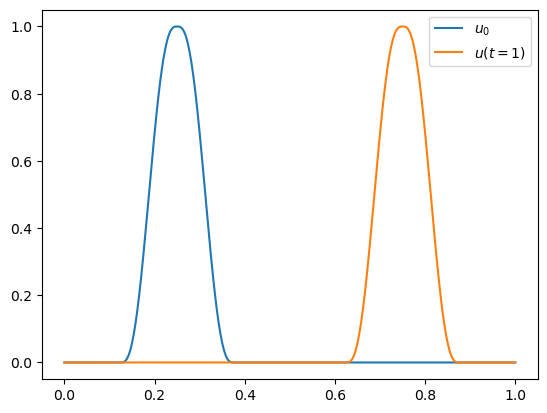

In [5]:
### On vérifie que la solution exacte fonctionne
X1 = np.linspace(0, 1, 501)
u0 = lambda x: u_init(x, 0, 1, 2)
u1 = solve_advection(u0, t_0=0, t=1, c=0.5)
plt.plot(X1, u0(X1), label="$u_0$")
plt.plot(X1, u1(X1), label="$u(t=1)$")
plt.legend()

On montre ici l'influence du paramètre de relaxation $s_1$ pour une advection à vitesse $c=0.5$ sur un réseau de vitesse $\lambda=1$ pour $n_x = 500$. On affiche les solutions à différents instant pour donner une idée de l'évolution de l'approximation LBM au cours du temps.

On observe que quand $s_1\in[0, 2]$ (et ici $|c| < \lambda$), plus $s_1$ est grand et plus la diffusion numérique est faible. Cette diffusion est très claire et vient du terme $$\sigma \Delta t (\lambda^2-c^2)\partial^2_{xx}m_0$$ dans l'équation équivalente à l'ordre 2 (où $\sigma=\frac{1}{s_1}-\frac{1}{2}$ le paramètre de Hénon) étant donné que la facteur devant la dérivée seconde est positif $$\sigma \Delta t (\lambda^2-c^2) > 0$$. Ce terme est de type "équation de la chaleur" et on comprend alors son effet d'écrasement au cours du déroulement de la simulation. On comprend aussi que puisque $\sigma \underset{s_1\rightarrow 2}{\longrightarrow} 0$, au bout d'un même temps $t_f$, cet écrasement est de moins en moins important à mesure que $s_1$ est proche de $2$.

A $s_1=2$ l'amplitude de la solution finale est visuellement la même que l'amplitude la solution exacte mais on observe que l'on est à la limite de convergence du schéma puisqu'il y a une très légère perte de positivité à $t_f=1$ en $x\approx0.65$. Comme le paramètre de Hénon vaut ici $0$, ce défaut vient des termes d'ordre 3 ou plus dans l'équation équivalente (que nous n'avons pas développés dans le cours).

Lorsque $s_1 > 2$ (même très légèrement) on observe que le schéma n'est pas convergent, ce qui est attendu car le schéma n'est alors pas stable au sens de von Neumann.

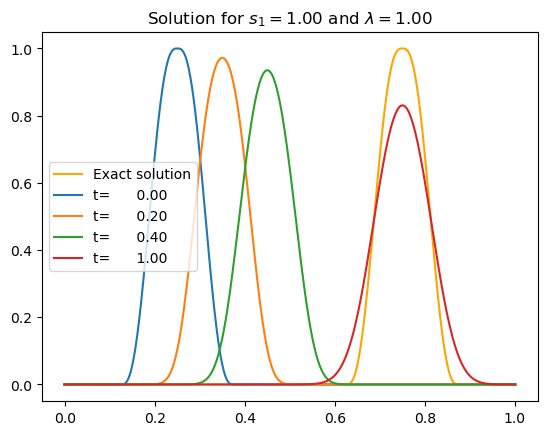

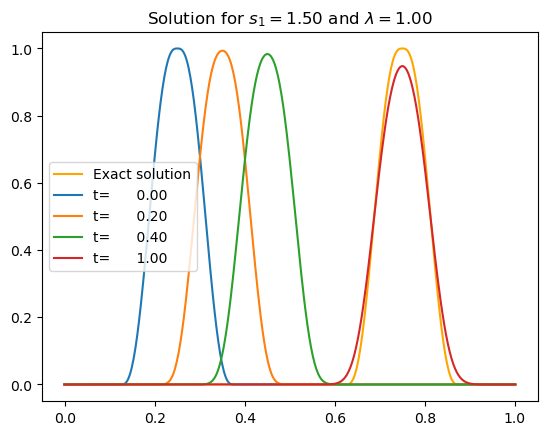

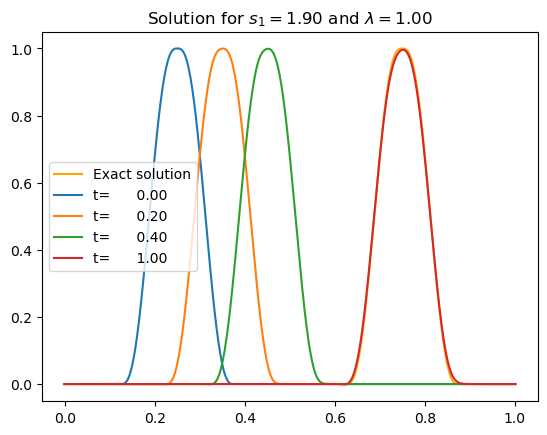

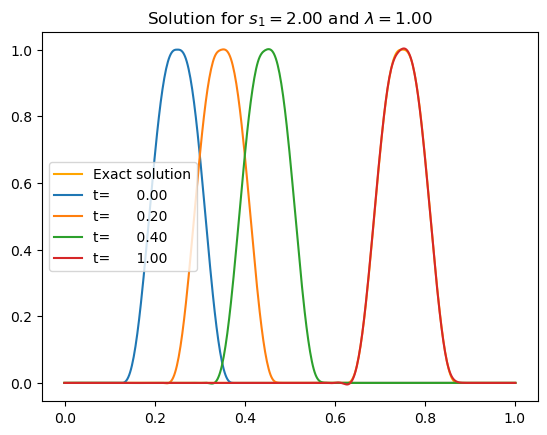

In [6]:
### Paramètres de la LBM
x_0, x_1, t_0, t_f = 0., 1., 0., 1.
nx = 500
lamb = 1.

### Outils pour l'advection
c = 0.5
m_1_eq = lambda m_0: c*m_0
def u_0(x):
    return u_init(x, 0, 1, 2)

### Try s_1 = 1.
s_1_1 = 1.
test1 = LBM_D1Q2(u_0, s_1_1, m_1_eq, nx, x_0, x_1, t_0, t_f, lamb)
test1.run()
test1.plot_m_0([0, 100, 200, 500], solve_advection(u_0, t_0, test1.true_final_time, c)(test1.X))

### Try s_1_2 = 1.5 > s_1_1
s_1_2 = 1.5
test2 = LBM_D1Q2(u_0, s_1_2, m_1_eq, nx, x_0, x_1, t_0, t_f)
test2.run()
test2.plot_m_0([0, 100, 200, 500], solve_advection(u_0, t_0, test2.true_final_time, c)(test2.X))

### Try s_1_3 = 1.9 > s_1_2
s_1_3 = 1.9
test3 = LBM_D1Q2(u_0, s_1_3, m_1_eq, nx, x_0, x_1, t_0, t_f)
test3.run()
test3.plot_m_0([0, 100, 200, 500], solve_advection(u_0, t_0, test3.true_final_time, c)(test3.X))

### Try s_1_4 = 2. the optimal parameter to avoid numerical diffusion
s_1_4 = 2.
test4 = LBM_D1Q2(u_0, s_1_4, m_1_eq, nx, x_0, x_1, t_0, t_f)
test4.run()
test4.plot_m_0([0, 100, 200, 500], solve_advection(u_0, t_0, test4.true_final_time, c)(test4.X))

### Try s_1_5 = 2.05 > 2. which should be not converge
s_1_5 = 2.05
test5 = LBM_D1Q2(u_0, s_1_5, m_1_eq, nx, x_0, x_1, t_0, t_f)
test5.run()
test5.plot_m_0([0, 100, 200, 500], solve_advection(u_0, t_0, test5.true_final_time, c)(test5.X))

### Q4

On montre ici le problème de choisir une vitesse supérieure à la vitesse du réseau rend le schéma instable (pour $s_1<2$ et $s_1=2$). On a pris une vitesse de réseau $\lambda=1$ et une une vitesse e transport $c_1 = 1.05$.

Ceci vient du fait que dans l'équation équivalente à l'ordre 2 $\sigma \Delta t (\lambda^2-c^2)\partial^2_{xx}m_0$, le terme $\sigma \Delta t (\lambda^2-c^2) < 0$, cet opérateur a un effet opposé à celui de la chaleur, au lieu d'un effet régularisant cela donne une évolution en sens (temporel) opposé (une distribution gaussienne se concentrera en un dirac au cours du temps).

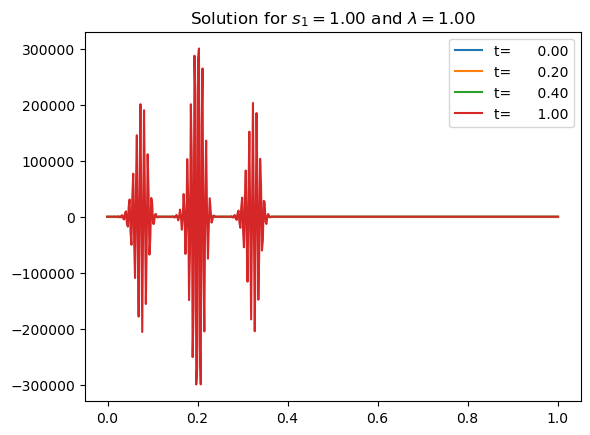

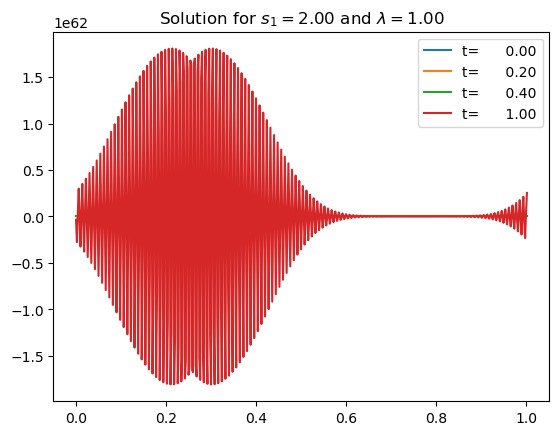

In [7]:
### Cas c > lambda et s_1 < 2
c1 = 1.05
m_1_eq1 = lambda m_0: c1*m_0

test6 = LBM_D1Q2(u_0, s_1_1, m_1_eq1, nx, x_0, x_1, t_0, t_f)
test6.run()
test6.plot_m_0([0, 100, 200, 500])

### Cas c > lambda et s_1 = 2
c2 = 1.05
m_1_eq2 = lambda m_0: c2*m_0
s_15 = 2.

test7 = LBM_D1Q2(u_0, s_15, m_1_eq2, nx, x_0, x_1, t_0, t_f)
test7.run()
test7.plot_m_0([0, 100, 200, 500])

### Q5

On cherche à trouver les ordres de convergence de la méthode LBM en espace pour une évolution de $t_0=0$ à $t_f=1$, une vitesse de réseau $\lambda=1$ sur une équation d'advection à vitesse $c=0.5$. pour différentes valeurs du paramètre $s_1\in[0, 1]$.

Pour calculer les ordres de convergence on calcule les erreurs pour une liste de $n_x$ entre $10^2$ et $10^{3.5}$ et on effectue un \texttt{numpy.polyfit} sur les 4 derniers points qui sont (au moins visuellement) sur la droite de convergence, ce qui nous donne une bonne approximation de l'ordre de convergence réel.

On remarque d'abord que pour $s_1=2$, l'ordre de convergence est bien comme attendu 2 (à très peu près).

Ensuite on voit que l'ordre de convergence est strictement inférieur à 1 pour $s_1\in[0, 1.9]$ mais s'en rapproche très fortement à $s_1=1.9$. De plus, pour $s_1=1.95$, l'ordre de convergence paraît être légèrement supérieur à 1. On peut probablement attribuer cela au fait que l'ordre réel pour $s_1<2$ est fractionnaire car l'influence du terme de diffusion dans le développement à l'ordre 2 du schéma diminue en importance, sont impact sur une solution au bout d'un temps $t_f$ peut peut-être être quantifié.

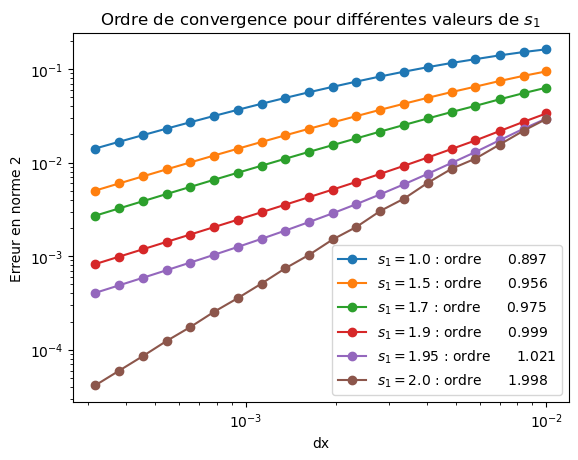

In [8]:
### Paramètres de la LBM
x_0, x_1, t_0, t_f = 0., 1., 0., 1.

s_1_list = [1., 1.5, 1.7, 1.9, 1.95, 2.]
c = 0.5
m_1_eq = lambda m_0: c*m_0

def u_0(x):
    return u_init(x, 0, 1, 2)

nx_list = np.logspace(2, 3.5, 20, dtype=int)

error_list = [[] for _ in s_1_list]
dx_list = []
for i in range(len(s_1_list)):
    for j in range(len(nx_list)):        
        temp = LBM_D1Q2(u_0, s_1_list[i], m_1_eq, nx_list[j], x_0, x_1, t_0, t_f, fast=True)
        temp.run_fast()

        if i==0:
            dx_list.append(temp.dx)

        exact_sol = solve_advection(u_0, t_0, temp.true_final_time, c)(temp.X)
        error = np.linalg.norm(exact_sol - temp.return_final_sol())/np.sqrt(nx_list[j])
        error_list[i].append(error)

dx_list = np.array(dx_list)
error_list = np.array(error_list)
for i in range(len(s_1_list)):
    order = np.polyfit(np.log(dx_list[-4:]), np.log(error_list[i,-4:]), 1)[0]
    plt.loglog(dx_list, error_list[i], label=f"$s_1={s_1_list[i]}$ : ordre {order:10.3f}", marker="o")
plt.title("Ordre de convergence pour différentes valeurs de $s_1$")
plt.xlabel("dx")
plt.ylabel("Erreur en norme 2")
plt.legend()
plt.show()

### Exercice 2

#### Q1

Pour que le schéma soit consistant avec l'équation de Bürgers il faut choisir $m_1^{eq} : m_0 \mapsto \dfrac{m_0^2}{2}$

#### Q2 / Q3

La discontinuité apparaît au temps $t=1$ pour une distribution initiale comme celle donnée par `solution_adimensionnee`. De sorte que dans l'exemple tracé ci-dessous, la discontinuité arrive au temps $t=0.25$ (les dimensions du chapeau interviennent). De plus, cet instant marque la formation d'un front qui commence à avancer.

On peut utiliser la méthode des caractéristiques pour montrer quand ce choc arrive. Prenons un cas général de distribution initiale fonction chapeau $u_0$ nulle en dehors de $[x_{min}, x_{max}]$, affine sur $[x_{min}, x_{c}]$ et sur $[x_{c}, x_{max}]$ telle que $u_0(x_c)=1$. On cherche les lignes caractéristiques $x(s), t(s)$, de sorte que $$0 = \dfrac{u[x(s), t(s)]}{ds} = \dfrac{dt}{ds}\dfrac{\partial u}{\partial t} + \dfrac{dx}{ds}\dfrac{\partial u}{\partial x}$$ avec $u$ solution de l'équation de Bürgers pour $\dfrac{dt}{ds}=1$, soit, si $t(0)=0$, $t(s)=s$ et $\dfrac{dx}{ds}=u$, soit, si $x(0)=x_0$ soit $x(s)=x_0+u(0, x_0)s$. Ainsi, on se rend compte qu'un choc se produit au temps $t(s)=s$ quand $x_0+u(0, x_0)s=x_1+u(0, x_1)s$ de sorte que si $u(0, \cdot) = u_0$, alors un choc se produit quand toutes les lignes caractéristiques issues de $[x_c, x_{max}[$ rencontrent la ligne caractéristique de $x_{max}$ qui est verticale $x(s)=x_{max}$. C'est-à-dire que le choc se produit à $$t(s) = s = \dfrac{x_{max}-x_c}{1-0}$$

In [9]:
def solution_adimensionnee (x, t):
    """
    A normalized hat solution of the Burgers equation
                         /\                      y=1
                        /  \
                       /    \
    __________________/      \__________________ y=0
                   x=-1  0    1
    """
    y = np. zeros (x. shape )
    if t < 0:
        return y
    if t < 1:
        xi = t
        indr = np. logical_and(x >= t, x < 1)
        y[indr] = 1 - 1/(1 - t) * (x[indr] - t)
    else :
        xi = 2 * np. sqrt(.5 * (1 + t)) - 1
    indl = np. logical_and(x >= -1, x <= xi)
    y[indl] = 1/(1 + t ) * (1 + x[indl])
    return y

def solution (x, t, xmin , xmax , ymax =1):
    """
    Hat solution of the Burgers equation
    adapted to the bounds of the figure
    """
    if ymax < 0:
        print ("Error ,  ymax  < 0 in  solution ")
        return
    middle, width = .75 * xmin + .25 * xmax , 0.125 * (xmax - xmin)
    xx = 1/width * (x - middle)
    return ymax * solution_adimensionnee(xx, ymax/width *t)

On observe le choc se produire en $t=0.25$ comme le prévoit la formule théorique calculée ci-dessus.

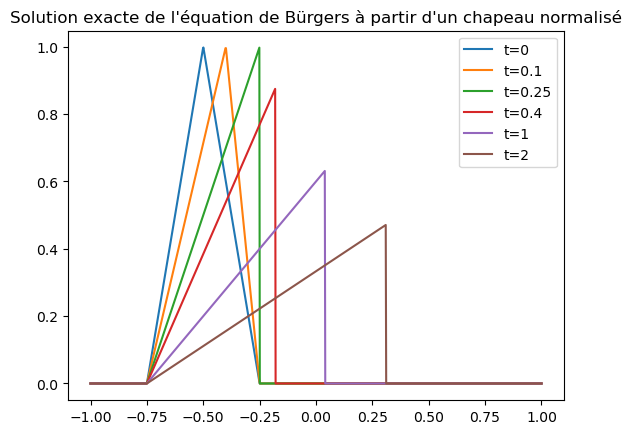

In [10]:
xx = np.linspace(-1, 1, 1000)
plt.plot(xx, solution(xx, 0, -1, 1), label="t=0")
plt.plot(xx, solution(xx, 0.1, -1, 1), label="t=0.1")
plt.plot(xx, solution(xx, 0.25, -1, 1), label="t=0.25")
plt.plot(xx, solution(xx, 0.4, -1, 1), label="t=0.4")
plt.plot(xx, solution(xx, 1, -1, 1), label="t=1")
plt.plot(xx, solution(xx, 2, -1, 1), label="t=2")
plt.title("Solution exacte de l'équation de Bürgers à partir d'un chapeau normalisé")
plt.legend()
plt.show()

### Q4 / Q5

La classe `LBM_D1Q2` permet de résoudre l'équation de Bürgers avec la méthode du D1Q2, il suffit de lui donner en argument la bonne fonction `m_1_eq`, c'est-à-dire celle donnée en question 1 du secon exercice du TP.

On va montrer quelques propriétés du schéma D1Q2, notamment sa stabilité en fonction de la régularité de la solution. Nous allons voir que lorsqu'un choc se prosuit, que la solution devie,nt discontinue, on observe une chute de l'ordre de convergence de la méthode quel que soit le paramètre de relaxation, de plus, nous allons voir que pour $s_1 = 2$, il n'y a tout simplement plus convergence.

On commence en faisant tourner la simulation sur $n_x=200$ points de discrétisation spatiale. On doit choisir alors quel vitesse de réseau est nécesssaire pour résoudre correctement le problème. Afin d'avoir une vitesse de transport locale inférieure à la vitesse du réseau, il nous faut prendre, si on note $\varphi = m_1^{eq}$, $\varphi'(m_0) = m_0 \leqslant \lambda$, soit ici (pour la distribution en chapeua initiale choisie), $\lambda \geqslant 1$.

On observe dans les trois prochaines figures, que pour $\lambda = 1$, on converge passé l'apparition de la discontinuité mais avec des oscillations et qu'en passant à $\lambda = 4$ puis $10$ on diminue cet effet. On pouvait s'y attendre, car en prenant de tels $\lambda$ on augmente l'effet lissant du terme type "équation de la chaleur" dans l'équation équivalente, de sorte que la solution est rapidement lissée et que le choc tend à disparaître. On s'attend donc à voir apparaître une chute de l'ordre de convergence en augmentant $s_1$ vers 2 car il fait disparaître ce terme "lissant". On a pris $n_x=200$ et $s_1 = 1.9$.

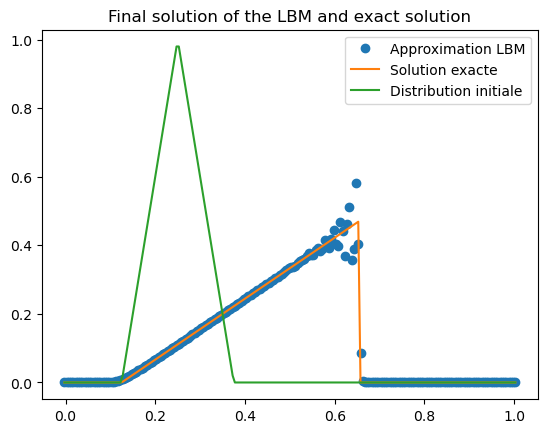

In [11]:
m_1_eq = lambda m_0: 0.5*m_0**2

s_1 = 1.9

x_0, x_1, t_0, t_f = 0., 1., 0., 1.
nx = 200

lamb = 1.

hat = lambda x: solution(x, 0, x_0, x_1)

lbm_sol_burgers = LBM_D1Q2(hat, s_1, m_1_eq, nx, x_0, x_1, t_0, t_f, lamb, fast=True)
lbm_sol_burgers.run_fast()
# On prend la solution exacte au vrai temps final
sol_exacte = solution(lbm_sol_burgers.X, lbm_sol_burgers.true_final_time, x_0, x_1)
lbm_sol_burgers.plot_final_sol_exact_sol_init_dist(sol_exacte, marker="o", linestyle='')

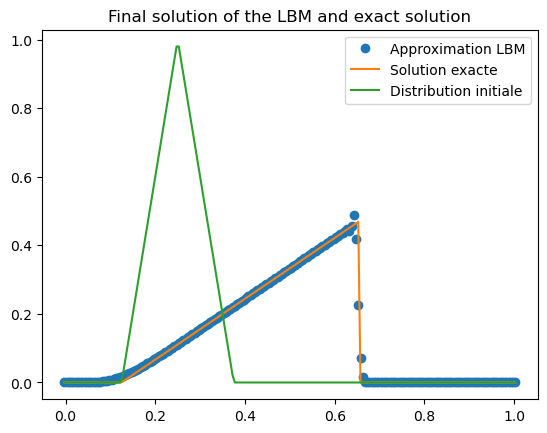

In [12]:
m_1_eq = lambda m_0: 0.5*m_0**2

s_1 = 1.9

x_0, x_1, t_0, t_f = 0., 1., 0., 1.
nx = 200

lamb = 4.

hat = lambda x: solution(x, 0, x_0, x_1)

lbm_sol_burgers = LBM_D1Q2(hat, s_1, m_1_eq, nx, x_0, x_1, t_0, t_f, lamb, fast=True)
lbm_sol_burgers.run_fast()
# On prend la solution exacte au vrai temps final
sol_exacte = solution(lbm_sol_burgers.X, lbm_sol_burgers.true_final_time, x_0, x_1)
lbm_sol_burgers.plot_final_sol_exact_sol_init_dist(sol_exacte, marker="o", linestyle='')

In [13]:
m_1_eq = lambda m_0: 0.5*m_0**2

s_1 = 1.9

x_0, x_1, t_0, t_f = 0., 1., 0., 1.
nx = 200

lamb = 10.

hat = lambda x: solution(x, 0, x_0, x_1)

lbm_sol_burgers = LBM_D1Q2(hat, s_1, m_1_eq, nx, x_0, x_1, t_0, t_f, lamb, fast=True)
lbm_sol_burgers.run_fast()
# On prend la solution exacte au vrai temps final
sol_exacte = solution(lbm_sol_burgers.X, lbm_sol_burgers.true_final_time, x_0, x_1)
lbm_sol_burgers.plot_final_sol_exact_sol_init_dist(sol_exacte, marker="o", linestyle='')

En approchant $s_1$ de 2 on voit qu'avec $\lambda =1$, les oscillations sont plus fortes, effectivement, la discontinuité est mieux conservée ce qui donne passé l'instant du choc une accentuation des oscillations.

In [18]:
m_1_eq = lambda m_0: 0.5*m_0**2

s_1 = 1.95 # Ici la légère augmentation de s_1 accentue les oscillations au niveau de la discontinuité

x_0, x_1, t_0, t_f = 0., 1., 0., 1.
nx = 200

lamb = 1.

hat = lambda x: solution(x, 0, x_0, x_1)

lbm_sol_burgers = LBM_D1Q2(hat, s_1, m_1_eq, nx, x_0, x_1, t_0, t_f, lamb, fast=True)
lbm_sol_burgers.run_fast()
# On prend la solution exacte au vrai temps final
sol_exacte = solution(lbm_sol_burgers.X, lbm_sol_burgers.true_final_time, x_0, x_1)
lbm_sol_burgers.plot_final_sol_exact_sol_init_dist(sol_exacte, marker="o", linestyle='')

Enfin, avec $s_1 = 2$, on ne converge plus, seule la propriété de positivité semble conservée, et ici augmenter $\lambda$ ne sert plus à rien, ce sont les termes d'ordre supérieurs dans l'équation équivalente qui prévalent (on ne les a pas calculé en cours). Le principe du maximum n'est plus respecté.

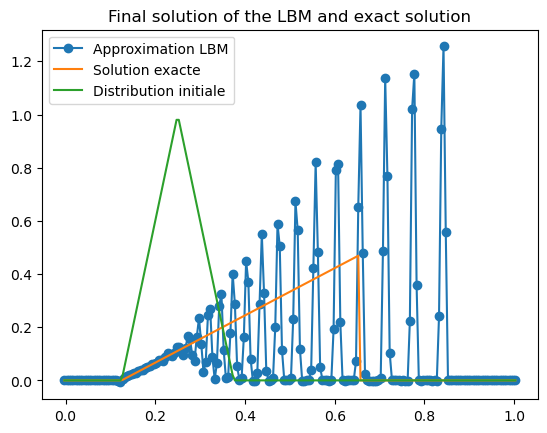

In [19]:
m_1_eq = lambda m_0: 0.5*m_0**2

s_1 = 2 # Arrivé à s_1 = 2, on perd le caractère convergeant du schéma

x_0, x_1, t_0, t_f = 0., 1., 0., 1.
nx = 200

lamb = 1.

hat = lambda x: solution(x, 0, x_0, x_1)

lbm_sol_burgers = LBM_D1Q2(hat, s_1, m_1_eq, nx, x_0, x_1, t_0, t_f, lamb, fast=True)
lbm_sol_burgers.run_fast()
# On prend la solution exacte au vrai temps final
sol_exacte = solution(lbm_sol_burgers.X, lbm_sol_burgers.true_final_time, x_0, x_1)
lbm_sol_burgers.plot_final_sol_exact_sol_init_dist(sol_exacte, marker="o", linestyle='-')

### Q6

On effectue une étude de la convergence, d'abord avec un temps final plus grand que l'apparition du choc, puis plus petit.

On prendra $\lambda = 4$, sinon la fonction polyfit ne converge pas dans les moindres carrés pour $s_1 = 2$.

On observe comme prévu une chute de l'ordre de convergence quel que soit $\lambda$. Il est intéressant de noter que, comme prévu on a plus convergence pour $s_1=2$ (ordre 0). Malgré les oscillations on observe que augmenter $s_1 < 2$ est utile car à $dx$ donné l'erreur est inférieure (pour un coût en temps de calul égal) malgré la diminution de l'ordre de convergence quand $s_1$ augmente. Les ordres de convergence pour $s_1<2$ sont eviron de 0.5.

(On a fait les interpolations linéaire pour avoir les ordres de convergence sur les 6 derniers points).

In [16]:
m_1_eq = lambda m_0: 0.5*m_0**2
s_1 = 1.9
x_0, x_1, t_0, t_f = 0., 1., 0., 1.

s_1_list = [1., 1.5, 1.7, 1.9, 2.]
nx_list = np.logspace(2, 3.5, 20, dtype=int)

lamb = 4.

m_0_0 = lambda x: solution(x, 0, x_0, x_1)

error_list = [[] for _ in s_1_list]
dx_list = []
for i in range(len(s_1_list)):
    for j in range(len(nx_list)):
        temp = LBM_D1Q2(m_0_0, s_1_list[i], m_1_eq, nx_list[j], x_0, x_1, t_0, t_f, lamb, fast=True)
        temp.run_fast()

        if i==0:
            dx_list.append(temp.dx)

        exact_sol = solution(temp.X, temp.true_final_time, x_0, x_1)
        error = np.linalg.norm(exact_sol - temp.return_final_sol())/np.sqrt(nx_list[j])
        error_list[i].append(error)

dx_list = np.array(dx_list)
error_list = np.array(error_list)
for i in range(len(s_1_list)):
    order = np.polyfit(np.log(dx_list[-6:]), np.log(error_list[i,-6:]), 1)[0]
    plt.loglog(dx_list, error_list[i], label=f"$s_1={s_1_list[i]}$ : ordre {order:10.3f}", marker="o")
plt.title("Ordre de convergence pour différentes valeurs de $s_1$ et après apparition de la discontinuité")
plt.xlabel("dx")
plt.ylabel("Erreur en norme 2")
plt.legend(loc="lower right")
plt.show()

Lorsque que l'on étudie l'ordre de convergence avant de passer la discontinuité, on observe une chute par rapport à l'exercie 1 de l'ordre pour chaque $s_1$. La régularité de la distribution initiale est donc iportante et si celle-ci n'est pas $\mathcal{C}^1$, alors on a plus d'ordre 2 pour $s_1=2$ mais un ordre 1 et plus d'ordre 1 pour $s_1<2$ mais un ordre autour de 0.75.

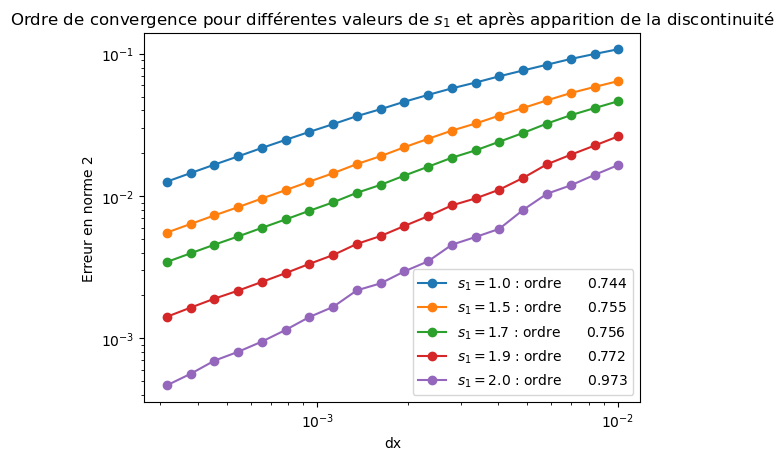

In [17]:
m_1_eq = lambda m_0: 0.5*m_0**2
s_1 = 1.9
x_0, x_1, t_0, t_f = 0., 1., 0., 0.1

s_1_list = [1., 1.5, 1.7, 1.9, 2.]
nx_list = np.logspace(2, 3.5, 20, dtype=int)

lamb = 4.

m_0_0 = lambda x: solution(x, 0, x_0, x_1)

error_list = [[] for _ in s_1_list]
dx_list = []
for i in range(len(s_1_list)):
    for j in range(len(nx_list)):
        temp = LBM_D1Q2(m_0_0, s_1_list[i], m_1_eq, nx_list[j], x_0, x_1, t_0, t_f, lamb, fast=True)
        temp.run_fast()

        if i==0:
            dx_list.append(temp.dx)

        exact_sol = solution(temp.X, temp.true_final_time, x_0, x_1)
        error = np.linalg.norm(exact_sol - temp.return_final_sol())/np.sqrt(nx_list[j])
        error_list[i].append(error)

dx_list = np.array(dx_list)
error_list = np.array(error_list)
for i in range(len(s_1_list)):
    order = np.polyfit(np.log(dx_list[-6:]), np.log(error_list[i,-6:]), 1)[0]
    plt.loglog(dx_list, error_list[i], label=f"$s_1={s_1_list[i]}$ : ordre {order:10.3f}", marker="o")
plt.title("Ordre de convergence pour différentes valeurs de $s_1$ et après apparition de la discontinuité")
plt.xlabel("dx")
plt.ylabel("Erreur en norme 2")
plt.legend(loc="lower right")
plt.show()